In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# clone from github repo directly
!git clone https://github.com/location-competition/indoor-location-competition-20
!mv ./indoor-location-competition-20/* ./

fatal: destination path 'indoor-location-competition-20' already exists and is not an empty directory.
mv: cannot stat './indoor-location-competition-20/*': No such file or directory


In [3]:
# check if GPU is available
import torch
print(torch.cuda.get_device_name(0))

Tesla T4


In [4]:
import glob
import json
import logging
import os
import random
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data import Dataset
from torchvision.models import resnet
from torchvision import transforms
from tqdm import tqdm
from collections import OrderedDict
from PIL import Image

In [5]:
device = 'cuda'  # if torch.cuda.is_initialized() else 'cpu'
torch.device(device)
print(device)

cuda


## Import Functions

### compute_f.py

In [6]:
# this cell contains the content from compute_f.py
import numpy as np
import scipy.signal as signal


def split_ts_seq(ts_seq, sep_ts):
    """

    :param ts_seq:
    :param sep_ts:
    :return:
    """
    tss = ts_seq[:, 0].astype(float)
    unique_sep_ts = np.unique(sep_ts)
    ts_seqs = []
    start_index = 0
    for i in range(0, unique_sep_ts.shape[0]):
        end_index = np.searchsorted(tss, unique_sep_ts[i], side='right')
        if start_index == end_index:
            continue
        ts_seqs.append(ts_seq[start_index:end_index, :].copy())
        start_index = end_index

    # tail data
    if start_index < ts_seq.shape[0]:
        ts_seqs.append(ts_seq[start_index:, :].copy())

    return ts_seqs


def correct_trajectory(original_xys, end_xy):
    """

    :param original_xys: numpy ndarray, shape(N, 2)
    :param end_xy: numpy ndarray, shape(1, 2)
    :return:
    """
    corrected_xys = np.zeros((0, 2))

    A = original_xys[0, :]
    B = end_xy
    Bp = original_xys[-1, :]

    angle_BAX = np.arctan2(B[1] - A[1], B[0] - A[0])
    angle_BpAX = np.arctan2(Bp[1] - A[1], Bp[0] - A[0])
    angle_BpAB = angle_BpAX - angle_BAX
    AB = np.sqrt(np.sum((B - A) ** 2))
    ABp = np.sqrt(np.sum((Bp - A) ** 2))

    corrected_xys = np.append(corrected_xys, [A], 0)
    for i in np.arange(1, np.size(original_xys, 0)):
        angle_CpAX = np.arctan2(original_xys[i, 1] - A[1], original_xys[i, 0] - A[0])

        angle_CAX = angle_CpAX - angle_BpAB

        ACp = np.sqrt(np.sum((original_xys[i, :] - A) ** 2))

        AC = ACp * AB / ABp

        delta_C = np.array([AC * np.cos(angle_CAX), AC * np.sin(angle_CAX)])

        C = delta_C + A

        corrected_xys = np.append(corrected_xys, [C], 0)

    return corrected_xys


def correct_positions(rel_positions, reference_positions):
    """

    :param rel_positions:
    :param reference_positions:
    :return:
    """
    rel_positions_list = split_ts_seq(rel_positions, reference_positions[:, 0])
    if len(rel_positions_list) != reference_positions.shape[0] - 1:
        # print(f'Rel positions list size: {len(rel_positions_list)}, ref positions size: {reference_positions.shape[0]}')
        del rel_positions_list[-1]
    assert len(rel_positions_list) == reference_positions.shape[0] - 1

    corrected_positions = np.zeros((0, 3))
    for i, rel_ps in enumerate(rel_positions_list):
        start_position = reference_positions[i]
        end_position = reference_positions[i + 1]
        abs_ps = np.zeros(rel_ps.shape)
        abs_ps[:, 0] = rel_ps[:, 0]
        # abs_ps[:, 1:3] = rel_ps[:, 1:3] + start_position[1:3]
        abs_ps[0, 1:3] = rel_ps[0, 1:3] + start_position[1:3]
        for j in range(1, rel_ps.shape[0]):
            abs_ps[j, 1:3] = abs_ps[j-1, 1:3] + rel_ps[j, 1:3]
        abs_ps = np.insert(abs_ps, 0, start_position, axis=0)
        corrected_xys = correct_trajectory(abs_ps[:, 1:3], end_position[1:3])
        corrected_ps = np.column_stack((abs_ps[:, 0], corrected_xys))
        if i == 0:
            corrected_positions = np.append(corrected_positions, corrected_ps, axis=0)
        else:
            corrected_positions = np.append(corrected_positions, corrected_ps[1:], axis=0)

    corrected_positions = np.array(corrected_positions)

    return corrected_positions


def init_parameters_filter(sample_freq, warmup_data, cut_off_freq=2):
    order = 4
    filter_b, filter_a = signal.butter(order, cut_off_freq / (sample_freq / 2), 'low', False)
    zf = signal.lfilter_zi(filter_b, filter_a)
    _, zf = signal.lfilter(filter_b, filter_a, warmup_data, zi=zf)
    _, filter_zf = signal.lfilter(filter_b, filter_a, warmup_data, zi=zf)

    return filter_b, filter_a, filter_zf


def get_rotation_matrix_from_vector(rotation_vector):
    q1 = rotation_vector[0]
    q2 = rotation_vector[1]
    q3 = rotation_vector[2]

    if rotation_vector.size >= 4:
        q0 = rotation_vector[3]
    else:
        q0 = 1 - q1*q1 - q2*q2 - q3*q3
        if q0 > 0:
            q0 = np.sqrt(q0)
        else:
            q0 = 0

    sq_q1 = 2 * q1 * q1
    sq_q2 = 2 * q2 * q2
    sq_q3 = 2 * q3 * q3
    q1_q2 = 2 * q1 * q2
    q3_q0 = 2 * q3 * q0
    q1_q3 = 2 * q1 * q3
    q2_q0 = 2 * q2 * q0
    q2_q3 = 2 * q2 * q3
    q1_q0 = 2 * q1 * q0

    R = np.zeros((9,))
    if R.size == 9:
        R[0] = 1 - sq_q2 - sq_q3
        R[1] = q1_q2 - q3_q0
        R[2] = q1_q3 + q2_q0

        R[3] = q1_q2 + q3_q0
        R[4] = 1 - sq_q1 - sq_q3
        R[5] = q2_q3 - q1_q0

        R[6] = q1_q3 - q2_q0
        R[7] = q2_q3 + q1_q0
        R[8] = 1 - sq_q1 - sq_q2

        R = np.reshape(R, (3, 3))
    elif R.size == 16:
        R[0] = 1 - sq_q2 - sq_q3
        R[1] = q1_q2 - q3_q0
        R[2] = q1_q3 + q2_q0
        R[3] = 0.0

        R[4] = q1_q2 + q3_q0
        R[5] = 1 - sq_q1 - sq_q3
        R[6] = q2_q3 - q1_q0
        R[7] = 0.0

        R[8] = q1_q3 - q2_q0
        R[9] = q2_q3 + q1_q0
        R[10] = 1 - sq_q1 - sq_q2
        R[11] = 0.0

        R[12] = R[13] = R[14] = 0.0
        R[15] = 1.0

        R = np.reshape(R, (4, 4))

    return R


def get_orientation(R):
    flat_R = R.flatten()
    values = np.zeros((3,))
    if np.size(flat_R) == 9:
        values[0] = np.arctan2(flat_R[1], flat_R[4])
        values[1] = np.arcsin(-flat_R[7])
        values[2] = np.arctan2(-flat_R[6], flat_R[8])
    else:
        values[0] = np.arctan2(flat_R[1], flat_R[5])
        values[1] = np.arcsin(-flat_R[9])
        values[2] = np.arctan2(-flat_R[8], flat_R[10])

    return values


def compute_steps(acce_datas):
    step_timestamps = np.array([])
    step_indexs = np.array([], dtype=int)
    step_acce_max_mins = np.zeros((0, 4))
    sample_freq = 50
    window_size = 22
    low_acce_mag = 0.6
    step_criterion = 1
    interval_threshold = 250

    acce_max = np.zeros((2,))
    acce_min = np.zeros((2,))
    acce_binarys = np.zeros((window_size,), dtype=int)
    acce_mag_pre = 0
    state_flag = 0

    warmup_data = np.ones((window_size,)) * 9.81
    filter_b, filter_a, filter_zf = init_parameters_filter(sample_freq, warmup_data)
    acce_mag_window = np.zeros((window_size, 1))

    # detect steps according to acceleration magnitudes
    for i in np.arange(0, np.size(acce_datas, 0)):
        acce_data = acce_datas[i, :]
        acce_mag = np.sqrt(np.sum(acce_data[1:] ** 2))

        acce_mag_filt, filter_zf = signal.lfilter(filter_b, filter_a, [acce_mag], zi=filter_zf)
        acce_mag_filt = acce_mag_filt[0]

        acce_mag_window = np.append(acce_mag_window, [acce_mag_filt])
        acce_mag_window = np.delete(acce_mag_window, 0)
        mean_gravity = np.mean(acce_mag_window)
        acce_std = np.std(acce_mag_window)
        mag_threshold = np.max([low_acce_mag, 0.4 * acce_std])

        # detect valid peak or valley of acceleration magnitudes
        acce_mag_filt_detrend = acce_mag_filt - mean_gravity
        if acce_mag_filt_detrend > np.max([acce_mag_pre, mag_threshold]):
            # peak
            acce_binarys = np.append(acce_binarys, [1])
            acce_binarys = np.delete(acce_binarys, 0)
        elif acce_mag_filt_detrend < np.min([acce_mag_pre, -mag_threshold]):
            # valley
            acce_binarys = np.append(acce_binarys, [-1])
            acce_binarys = np.delete(acce_binarys, 0)
        else:
            # between peak and valley
            acce_binarys = np.append(acce_binarys, [0])
            acce_binarys = np.delete(acce_binarys, 0)

        if (acce_binarys[-1] == 0) and (acce_binarys[-2] == 1):
            if state_flag == 0:
                acce_max[:] = acce_data[0], acce_mag_filt
                state_flag = 1
            elif (state_flag == 1) and ((acce_data[0] - acce_max[0]) <= interval_threshold) and (
                    acce_mag_filt > acce_max[1]):
                acce_max[:] = acce_data[0], acce_mag_filt
            elif (state_flag == 2) and ((acce_data[0] - acce_max[0]) > interval_threshold):
                acce_max[:] = acce_data[0], acce_mag_filt
                state_flag = 1

        # choose reasonable step criterion and check if there is a valid step
        # save step acceleration data: step_acce_max_mins = [timestamp, max, min, variance]
        step_flag = False
        if step_criterion == 2:
            if (acce_binarys[-1] == -1) and ((acce_binarys[-2] == 1) or (acce_binarys[-2] == 0)):
                step_flag = True
        elif step_criterion == 3:
            if (acce_binarys[-1] == -1) and (acce_binarys[-2] == 0) and (np.sum(acce_binarys[:-2]) > 1):
                step_flag = True
        else:
            if (acce_binarys[-1] == 0) and acce_binarys[-2] == -1:
                if (state_flag == 1) and ((acce_data[0] - acce_min[0]) > interval_threshold):
                    acce_min[:] = acce_data[0], acce_mag_filt
                    state_flag = 2
                    step_flag = True
                elif (state_flag == 2) and ((acce_data[0] - acce_min[0]) <= interval_threshold) and (
                        acce_mag_filt < acce_min[1]):
                    acce_min[:] = acce_data[0], acce_mag_filt
        if step_flag:
            step_timestamps = np.append(step_timestamps, acce_data[0])
            step_indexs = np.append(step_indexs, [i])
            step_acce_max_mins = np.append(step_acce_max_mins,
                                           [[acce_data[0], acce_max[1], acce_min[1], acce_std ** 2]], axis=0)
        acce_mag_pre = acce_mag_filt_detrend

    return step_timestamps, step_indexs, step_acce_max_mins


def compute_stride_length(step_acce_max_mins):
    K = 0.4
    K_max = 0.8
    K_min = 0.4
    para_a0 = 0.21468084
    para_a1 = 0.09154517
    para_a2 = 0.02301998

    stride_lengths = np.zeros((step_acce_max_mins.shape[0], 2))
    k_real = np.zeros((step_acce_max_mins.shape[0], 2))
    step_timeperiod = np.zeros((step_acce_max_mins.shape[0] - 1, ))
    stride_lengths[:, 0] = step_acce_max_mins[:, 0]
    window_size = 2
    step_timeperiod_temp = np.zeros((0, ))

    # calculate every step period - step_timeperiod unit: second
    for i in range(0, step_timeperiod.shape[0]):
        step_timeperiod_data = (step_acce_max_mins[i + 1, 0] - step_acce_max_mins[i, 0]) / 1000
        step_timeperiod_temp = np.append(step_timeperiod_temp, [step_timeperiod_data])
        if step_timeperiod_temp.shape[0] > window_size:
            step_timeperiod_temp = np.delete(step_timeperiod_temp, [0])
        step_timeperiod[i] = np.sum(step_timeperiod_temp) / step_timeperiod_temp.shape[0]

    # calculate parameters by step period and acceleration magnitude variance
    k_real[:, 0] = step_acce_max_mins[:, 0]
    k_real[0, 1] = K
    for i in range(0, step_timeperiod.shape[0]):
        k_real[i + 1, 1] = np.max([(para_a0 + para_a1 / step_timeperiod[i] + para_a2 * step_acce_max_mins[i, 3]), K_min])
        k_real[i + 1, 1] = np.min([k_real[i + 1, 1], K_max]) * (K / K_min)

    # calculate every stride length by parameters and max and min data of acceleration magnitude
    stride_lengths[:, 1] = np.max([(step_acce_max_mins[:, 1] - step_acce_max_mins[:, 2]),
                                   np.ones((step_acce_max_mins.shape[0], ))], axis=0)**(1 / 4) * k_real[:, 1]

    return stride_lengths


def compute_headings(ahrs_datas):
    headings = np.zeros((np.size(ahrs_datas, 0), 2))
    for i in np.arange(0, np.size(ahrs_datas, 0)):
        ahrs_data = ahrs_datas[i, :]
        rot_mat = get_rotation_matrix_from_vector(ahrs_data[1:])
        azimuth, pitch, roll = get_orientation(rot_mat)
        around_z = (-azimuth) % (2 * np.pi)
        headings[i, :] = ahrs_data[0], around_z
    return headings


def compute_step_heading(step_timestamps, headings):
    step_headings = np.zeros((len(step_timestamps), 2))
    step_timestamps_index = 0
    for i in range(0, len(headings)):
        if step_timestamps_index < len(step_timestamps):
            if headings[i, 0] == step_timestamps[step_timestamps_index]:
                step_headings[step_timestamps_index, :] = headings[i, :]
                step_timestamps_index += 1
        else:
            break
    assert step_timestamps_index == len(step_timestamps)

    return step_headings


def compute_rel_positions(stride_lengths, step_headings):
    rel_positions = np.zeros((stride_lengths.shape[0], 3))
    for i in range(0, stride_lengths.shape[0]):
        rel_positions[i, 0] = stride_lengths[i, 0]
        rel_positions[i, 1] = -stride_lengths[i, 1] * np.sin(step_headings[i, 1])
        rel_positions[i, 2] = stride_lengths[i, 1] * np.cos(step_headings[i, 1])

    return rel_positions


def compute_step_positions(acce_datas, ahrs_datas, posi_datas):
    step_timestamps, step_indexs, step_acce_max_mins = compute_steps(acce_datas)
    headings = compute_headings(ahrs_datas)
    stride_lengths = compute_stride_length(step_acce_max_mins)
    step_headings = compute_step_heading(step_timestamps, headings)
    rel_positions = compute_rel_positions(stride_lengths, step_headings)
    step_positions = correct_positions(rel_positions, posi_datas)

    return step_positions

### io_f.py

In [7]:
# this cell contain the content from io_f.py
from dataclasses import dataclass

import numpy as np


@dataclass
class ReadData:
  acce: np.ndarray
  acce_uncali: np.ndarray
  gyro: np.ndarray
  gyro_uncali: np.ndarray
  magn: np.ndarray
  magn_uncali: np.ndarray
  ahrs: np.ndarray
  wifi: np.ndarray
  ibeacon: np.ndarray
  waypoint: np.ndarray


def read_data_file(data_filename):
  acce = []
  acce_uncali = []
  gyro = []
  gyro_uncali = []
  magn = []
  magn_uncali = []
  ahrs = []
  wifi = []
  ibeacon = []
  waypoint = []

  with open(data_filename, 'r', encoding='utf-8') as file:
    lines = file.readlines()

  for line_data in lines:
    line_data = line_data.strip()
    if not line_data or line_data[0] == '#':
      continue

    line_data = line_data.split('\t')

    if line_data[1] == 'TYPE_ACCELEROMETER':
      acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
      continue

    if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
      acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
      continue

    if line_data[1] == 'TYPE_GYROSCOPE':
      gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
      continue

    if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
      gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
      continue

    if line_data[1] == 'TYPE_MAGNETIC_FIELD':
      magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
      continue

    if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
      magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
      continue

    if line_data[1] == 'TYPE_ROTATION_VECTOR':
      ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
      continue

    if line_data[1] == 'TYPE_WIFI':
      sys_ts = line_data[0]
      ssid = line_data[2]
      bssid = line_data[3]
      rssi = line_data[4]
      lastseen_ts = line_data[6]
      wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
      wifi.append(wifi_data)
      continue

    if line_data[1] == 'TYPE_BEACON':
      ts = line_data[0]
      uuid = line_data[2]
      major = line_data[3]
      minor = line_data[4]
      rssi = line_data[6]
      ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
      ibeacon.append(ibeacon_data)
      continue

    if line_data[1] == 'TYPE_WAYPOINT':
      waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

  acce = np.array(acce)
  acce_uncali = np.array(acce_uncali)
  gyro = np.array(gyro)
  gyro_uncali = np.array(gyro_uncali)
  magn = np.array(magn)
  magn_uncali = np.array(magn_uncali)
  ahrs = np.array(ahrs)
  wifi = np.array(wifi)
  ibeacon = np.array(ibeacon)
  waypoint = np.array(waypoint)

  return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

def read_data_files(path_file_list):
  file_data_map = {}
  for path_filename in path_file_list:
    file_data_map[path_filename] = read_data_file(path_filename)
  return file_data_map

### visualize_f.py

In [8]:
# this cell contains the content from visualize_f.py
import plotly.graph_objs as go
from PIL import Image


# def save_figure_to_html(fig, filename):
#     fig.write_html(filename)


def visualize_trajectory(trajectory, floor_plan_filename, width_meter, height_meter, title=None, mode='lines + markers + text', show=False):
    fig = go.Figure()

    # add trajectory
    size_list = [6] * trajectory.shape[0]
    size_list[0] = 10
    size_list[-1] = 10

    color_list = ['rgba(4, 174, 4, 0.5)'] * trajectory.shape[0]
    color_list[0] = 'rgba(12, 5, 235, 1)'
    color_list[-1] = 'rgba(235, 5, 5, 1)'

    position_count = {}
    text_list = []
    for i in range(trajectory.shape[0]):
        if str(trajectory[i]) in position_count:
            position_count[str(trajectory[i])] += 1
        else:
            position_count[str(trajectory[i])] = 0
        text_list.append('        ' * position_count[str(trajectory[i])] + f'{i}')
    text_list[0] = 'Start Point: 0'
    text_list[-1] = f'End Point: {trajectory.shape[0] - 1}'

    fig.add_trace(
        go.Scattergl(
            x=trajectory[:, 0],
            y=trajectory[:, 1],
            mode=mode,
            marker=dict(size=size_list, color=color_list),
            line=dict(shape='linear', color='rgb(100, 10, 100)', width=2, dash='dot'),
            text=text_list,
            textposition="top center",
            name='trajectory',
        ))

    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])

    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        title=go.layout.Title(
            text=title or "No title.",
            xref="paper",
            x=0,
        ),
        autosize=True,
        width=900,
        height=200 + 900 * height_meter / width_meter,
        template="plotly_white",
    )

    if show:
        fig.show()

    return fig


def visualize_heatmap(position, value, floor_plan_filename, width_meter, height_meter, colorbar_title="colorbar", title=None, show=False):
    fig = go.Figure()

    # add heat map
    fig.add_trace(
        go.Scatter(x=position[:, 0],
                   y=position[:, 1],
                   mode='markers',
                   marker=dict(size=7,
                               color=value,
                               colorbar=dict(title=colorbar_title),
                               colorscale="Rainbow"),
                   text=value,
                   name=title))

    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])

    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        title=go.layout.Title(
            text=title or "No title.",
            xref="paper",
            x=0,
        ),
        autosize=True,
        width=900,
        height=200 + 900 * height_meter / width_meter,
        template="plotly_white",
    )

    if show:
        fig.show()

    return fig


### Calibrate and Extract for Magnetic, WiFi and iBeacon

In [9]:
def calibrate_magnetic_wifi_ibeacon_to_position(path_file_list):
    mwi_datas = {}
    for path_filename in path_file_list:
        print(f'Processing {path_filename}...')

        path_datas = read_data_file(path_filename)
        acce_datas = path_datas.acce
        magn_datas = path_datas.magn
        ahrs_datas = path_datas.ahrs
        wifi_datas = path_datas.wifi
        ibeacon_datas = path_datas.ibeacon
        posi_datas = path_datas.waypoint

        step_positions = compute_step_positions(acce_datas, ahrs_datas, posi_datas)
        # visualize_trajectory(posi_datas[:, 1:3], floor_plan_filename, width_meter, height_meter, title='Ground Truth', show=True)
        # visualize_trajectory(step_positions[:, 1:3], floor_plan_filename, width_meter, height_meter, title='Step Position', show=True)

        if wifi_datas.size != 0:
            sep_tss = np.unique(wifi_datas[:, 0].astype(float))
            wifi_datas_list = split_ts_seq(wifi_datas, sep_tss)
            for wifi_ds in wifi_datas_list:
                diff = np.abs(step_positions[:, 0] - float(wifi_ds[0, 0]))
                index = np.argmin(diff)
                target_xy_key = tuple(step_positions[index, 1:3])
                if target_xy_key in mwi_datas:
                    mwi_datas[target_xy_key]['wifi'] = np.append(mwi_datas[target_xy_key]['wifi'], wifi_ds, axis=0)
                else:
                    mwi_datas[target_xy_key] = {
                        'magnetic': np.zeros((0, 4)),
                        'wifi': wifi_ds,
                        'ibeacon': np.zeros((0, 3))
                    }

        if ibeacon_datas.size != 0:
            sep_tss = np.unique(ibeacon_datas[:, 0].astype(float))
            ibeacon_datas_list = split_ts_seq(ibeacon_datas, sep_tss)
            for ibeacon_ds in ibeacon_datas_list:
                diff = np.abs(step_positions[:, 0] - float(ibeacon_ds[0, 0]))
                index = np.argmin(diff)
                target_xy_key = tuple(step_positions[index, 1:3])
                if target_xy_key in mwi_datas:
                    mwi_datas[target_xy_key]['ibeacon'] = np.append(mwi_datas[target_xy_key]['ibeacon'], ibeacon_ds, axis=0)
                else:
                    mwi_datas[target_xy_key] = {
                        'magnetic': np.zeros((0, 4)),
                        'wifi': np.zeros((0, 5)),
                        'ibeacon': ibeacon_ds
                    }

        sep_tss = np.unique(magn_datas[:, 0].astype(float))
        magn_datas_list = split_ts_seq(magn_datas, sep_tss)
        for magn_ds in magn_datas_list:
            diff = np.abs(step_positions[:, 0] - float(magn_ds[0, 0]))
            index = np.argmin(diff)
            target_xy_key = tuple(step_positions[index, 1:3])
            if target_xy_key in mwi_datas:
                mwi_datas[target_xy_key]['magnetic'] = np.append(mwi_datas[target_xy_key]['magnetic'], magn_ds, axis=0)
            else:
                mwi_datas[target_xy_key] = {
                    'magnetic': magn_ds,
                    'wifi': np.zeros((0, 5)),
                    'ibeacon': np.zeros((0, 3))
                }

    return mwi_datas


def extract_magnetic_strength(mwi_datas):
    magnetic_strength = {}
    for position_key in mwi_datas:
        # print(f'Position: {position_key}')

        magnetic_data = mwi_datas[position_key]['magnetic']
        magnetic_s = np.mean(np.sqrt(np.sum(magnetic_data[:, 1:4] ** 2, axis=1)))
        magnetic_strength[position_key] = magnetic_s

    return magnetic_strength


def extract_wifi_rssi(mwi_datas):
    wifi_rssi = {}
    for position_key in mwi_datas:
        # print(f'Position: {position_key}')

        wifi_data = mwi_datas[position_key]['wifi']
        for wifi_d in wifi_data:
            bssid = wifi_d[2]
            rssi = int(wifi_d[3])

            if bssid in wifi_rssi:
                position_rssi = wifi_rssi[bssid]
                if position_key in position_rssi:
                    old_rssi = position_rssi[position_key][0]
                    old_count = position_rssi[position_key][1]
                    position_rssi[position_key][0] = (old_rssi * old_count + rssi) / (old_count + 1)
                    position_rssi[position_key][1] = old_count + 1
                else:
                    position_rssi[position_key] = np.array([rssi, 1])
            else:
                position_rssi = {}
                position_rssi[position_key] = np.array([rssi, 1])

            wifi_rssi[bssid] = position_rssi

    return wifi_rssi


def extract_ibeacon_rssi(mwi_datas):
    ibeacon_rssi = {}
    for position_key in mwi_datas:
        # print(f'Position: {position_key}')

        ibeacon_data = mwi_datas[position_key]['ibeacon']
        for ibeacon_d in ibeacon_data:
            ummid = ibeacon_d[1]
            rssi = int(ibeacon_d[2])

            if ummid in ibeacon_rssi:
                position_rssi = ibeacon_rssi[ummid]
                if position_key in position_rssi:
                    old_rssi = position_rssi[position_key][0]
                    old_count = position_rssi[position_key][1]
                    position_rssi[position_key][0] = (old_rssi * old_count + rssi) / (old_count + 1)
                    position_rssi[position_key][1] = old_count + 1
                else:
                    position_rssi[position_key] = np.array([rssi, 1])
            else:
                position_rssi = {}
                position_rssi[position_key] = np.array([rssi, 1])

            ibeacon_rssi[ummid] = position_rssi

    return ibeacon_rssi


def extract_wifi_count(mwi_datas):
    wifi_counts = {}
    for position_key in mwi_datas:
        # print(f'Position: {position_key}')

        wifi_data = mwi_datas[position_key]['wifi']
        count = np.unique(wifi_data[:, 2]).shape[0]
        wifi_counts[position_key] = count

    return wifi_counts

## Dataset

In [10]:
class FloorData(object):
  """Class represents one floor.
  """

  def __init__(self, output_path, path='./data/site1/F1',
                logger=logging, shuffle=True):
      self.shuffle = shuffle
      if not os.path.isdir(output_path):
          os.makedirs(output_path)
      self.path = path
      self.output_path = output_path
      self.path_data_dir = self.path = path + '/path_data_files'
      self.floor_plan_filename = self.path = path + '/floor_image.png'
      floor_info_filename = self.path = path + '/floor_info.json'
      with open(floor_info_filename) as f:
          self.floor_info = json.load(f)

      self.width_meter = self.floor_info["map_info"]["width"]
      self.height_meter = self.floor_info["map_info"]["height"]
      self.logger = logger
      self.parse_data()

  def parse_data(self):
      self.logger.info("Parse data from %s" % self.path)
      path_filenames = glob.glob(os.path.join(self.path_data_dir, "*.txt"))
      # Raw data, used to plot positions
      self.raw_data = read_data_files(path_filenames)
      # Calibrated data, used to draw magnetic, wifi, etc.
      self.data = calibrate_magnetic_wifi_ibeacon_to_position(self.raw_data)

      magnetic_strength = extract_magnetic_strength(self.data)
      wifi_rssi = extract_wifi_rssi(self.data)  # {wifi id: {pos1: value,pos2:value...}...}
      ibeacon_rssi = extract_ibeacon_rssi(self.data)  # {ibeacon id: {pos1: value,pos2:value...}...}
      wifi_count = extract_wifi_count(self.data)

      wifi_rssi = OrderedDict(wifi_rssi)
      ibeacon_rssi = OrderedDict(ibeacon_rssi)

      example = OrderedDict()
      for pos in self.data.keys():
          example[pos] = np.zeros((1 + len(wifi_rssi.keys()) + len(ibeacon_rssi.keys()),))

      for position, magnet_s in magnetic_strength.items():
          if position not in example.keys():
              raise ('there is an extra position')
          example[position][0] = magnet_s

      for wifi_id, pos_rssi_dict in wifi_rssi.items():
          for pos, rssi in pos_rssi_dict.items():
              if pos not in example.keys():
                  raise ('there is an extra position')
              example[pos][1 + list(wifi_rssi.keys()).index(wifi_id)] = rssi[0] 
              # example[pos][list(wifi_rssi.keys()).index(wifi_id)] = rssi[0] 

      for ibeacon_id, pos_rssi_dict in ibeacon_rssi.items():
          for pos, rssi in pos_rssi_dict.items():
              if pos not in example.keys():
                  raise ('there is an extra position')
              example[pos][1 + len(wifi_rssi.keys()) + list(ibeacon_rssi.keys()).index(ibeacon_id)] = rssi[0]
              # example[pos][list(ibeacon_rssi.keys()).index(ibeacon_id)] = rssi[0]

      # Normalization
      self.example = example
      self.gt = np.array(list(example.keys()))
      self.feature = np.array(list(example.values()))
      self.feature_max = self.feature.max(axis=0, keepdims=True)
      self.feature_min = self.feature.min(axis=0, keepdims=True)
      self.gt[:, 0] = self.gt[:, 0] / self.width_meter
      self.gt[:, 1] = self.gt[:, 1] / self.height_meter
      self.feature = (self.feature - self.feature_min) / (self.feature_max - self.feature_min)
      self.feature_length = self.feature.shape[1]
      self.output_length = self.gt.shape[1]
      self.index = np.arange(self.feature.shape[0])
      if self.shuffle:
          np.random.shuffle(self.index)
      self.train_ratio = 0.6
      self.val_ratio = 0.2
      self.test_ratio = 0.2

  def __len__(self):
      return len(self.index)

  def get_train(self):
      idx = self.index[:int(len(self) * self.train_ratio)]
      return self.feature[idx, ...], self.gt[idx, ...]
  
  def get_val(self):
      idx = self.index[(int(len(self) * self.train_ratio)):(int(len(self) * (1-self.val_ratio)))]
      return self.feature[idx, ...], self.gt[idx, ...]

  def get_test(self):
      # idx = self.index[int(len(self) * self.train_ratio):]
      idx = self.index[int(len(self) * (1-self.test_ratio)):]
      return self.feature[idx, ...], self.gt[idx, ...]

In [11]:
class SplitDataset(Dataset):
    def __init__(self, ds, type='train', shuffle=True):
        self.ds = ds
        if type == 'train':
            self.feature, self.label = self.ds.get_train()
        elif type == 'val':
            self.feature, self.label = self.ds.get_val()
        elif type == 'test':
            self.feature, self.label = self.ds.get_test()
        elif type == 'all':
            self.feature = self.ds.feature
            self.label = self.ds.gt

        def _map(array):
            if not isinstance(array, torch.Tensor):
                array = torch.from_numpy(array).float()
            return array

        self.feature = _map(self.feature)
        self.label = _map(self.label)
        self.image = Image.open(ds.floor_plan_filename).convert('RGB')
        self.trans = torchvision.transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5),
        ])
        self.img = self.trans(self.image)
        self.index = np.arange(len(self))
        if shuffle:
            np.random.shuffle(self.index)

    def pin_memory(self):
        self.feature = self.feature.pin_memory()
        self.label = self.label.pin_memory()
        self.img = self.img.pin_memory()

    def __len__(self):
        return self.feature.shape[0]

    def __getitem__(self, index):
        idx = self.index[index]
        feature = self.feature[idx, ...]
        img = self.img
        if True:
            feature += (1e-3 * torch.randn(feature.size()).float().to(feature.device))
            img += (1e-3 * torch.randn(img.size()).float().to(img.device))
        return feature, self.label[idx, ...], img

## MLP Model

In [12]:
class MLP(nn.Module):
  def __init__(self, input_size, h1_size, h2_size, output_size):
    super(MLP, self).__init__()
    self.model = nn.Sequential(nn.Linear(input_size+3*28*28, h1_size),  # in 3860 out: 512 
                  nn.ReLU(),
                  nn.Linear(h1_size, h2_size),       # in: 512 out: 4096
                  nn.ReLU(),
                  nn.Linear(h2_size, 64),          # in: 4096 out: 64
                  nn.ReLU(),
                  nn.Linear(64, 32),            # in: 64 out: 32
                  nn.ReLU(),
                  nn.Linear(32, output_size))        # in: 32 out: 2

  def forward(self, feature, image):
    x = image.view(-1, image.size()[1] * image.size()[2] * image.size()[3])  # 3*28*28
    out = torch.cat([feature, x], axis=-1)
    if torch.isnan(out).any(): exit(1)
    preds = self.model(out)
    return preds

class MLP_ResNet(nn.Module):
  def __init__(self, inputsize, h1size, h2size, outputsize):
    super(MLP_ResNet, self).__init__()
    self.model = nn.Sequential(nn.Linear(inputsize, h1size),
                  nn.ReLU(),
                  nn.Linear(h1size, h2size),
                  nn.ReLU(),
                  nn.Linear(h2size, h2size),
                  nn.ReLU())
    self.head = nn.Sequential(nn.Linear(h2size+64, 512), #h2_size + 1024
                  nn.ReLU(),
                  nn.Linear(512, h2size),
                  nn.ReLU(),
                  nn.Linear(h2size, 64),
                  nn.ReLU(),
                  nn.Linear(64, 32),
                  nn.ReLU(),
                  nn.Linear(32, outputsize))
    self.backbone = resnet.resnet18(pretrained=True, progress=True)
    self.backbone.layer4 = nn.Sequential()
    self.reduce_chn = nn.Sequential(nn.Conv2d(256, 16, kernel_size=1),
                     nn.BatchNorm2d(16),
                     nn.ReLU())

  def forward(self, feature, image):
    x = self.backbone.conv1(image)
    x = self.backbone.bn1(x)
    x = self.backbone.relu(x)
    x = self.backbone.maxpool(x)

    x = self.backbone.layer1(x)
    x = self.backbone.layer2(x)
    x = self.backbone.layer3(x)
    x = self.reduce_chn(x)
    b, _, _, _ = x.shape
    x = x.view((b, -1))
    # x = x.view((x.size(0), -1))
    f = self.model(feature)
    out = torch.cat([f, x], axis=-1)

    return self.head(out)

class CNN(nn.Module):
  def __init__(self, n_input, n_output):
    super().__init__()
    self.lin1 = nn.Linear(in_features=n_input, out_features=512)
    self.lin2 = nn.Linear(in_features=512,     out_features=32)
    self.lin3 = nn.Linear(in_features=32,      out_features=n_output)
    self.bn1 = nn.BatchNorm1d(512)
    self.bn2 = nn.BatchNorm1d(32)
    self.drops = nn.Dropout(0.3)        

  def forward(self, feature, image):
      x = image.view(-1, image.size()[1] * image.size()[2] * image.size()[3])
      numBatches = x.shape[0]
      x = F.relu(self.lin1(x))
      x = self.drops(x)
      
      ## batchnorm doesnt work for batchsize of 1
      if numBatches > 1:
          x = self.bn1(x)
          x = F.relu(self.lin2(x))
          x = self.drops(x)
          x = self.bn2(x)
          x = self.lin3(x)
      else:
          x = F.relu(self.lin2(x))
          x = self.drops(x)
          x = self.lin3(x)
      b, _, _, _ = x.shape
      x = x.view((b, -1))
      # x = x.view((x.size(0), -1))
      f = self.model(feature)
      out = torch.cat([f, x], axis=-1)

      return self.head(out)

## Training and Validation

In [13]:
def init_weights(m):
  if type(m) == nn.Linear:
    torch.nn.init.xavier_uniform(m.weight)
    if m.bias is not None:
      m.bias.data.fill_(0.01)


def train(network, train_dataset, test_dataset, train_loss_list, test_loss_list):
  network.apply(init_weights)
  network.to(device=device)
  sampler = RandomSampler(train_dataset)
  train_data_loader = DataLoader(train_dataset, sampler=sampler, batch_size=128, pin_memory=torch.cuda.is_initialized())
  test_data_loader = DataLoader(test_dataset, batch_size=32, pin_memory=torch.cuda.is_initialized())
  optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
  # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
  criterion = torch.nn.MSELoss().to(device)
  avg_loss = 0.0
  avg_loss_prev = 0.0
  same_loss_count = 0

  # exit()
  for epoch in range(50):
    epoch_iterator = tqdm(train_data_loader, desc='Iteration', disable=True)
    network.train()
    loss_sum = 0.0
    count = 0
    for step, batch in enumerate(epoch_iterator):
      example, label, image = map(lambda x: x.to(device), batch)
      preds = network(example, image)
      optimizer.zero_grad()
      network.zero_grad()
      loss = criterion(preds, label)
      # print(loss)
      if torch.isnan(loss):
        exit()
      loss.backward()
      optimizer.step()

      loss_sum += loss.detach().cpu().item()
      count += 1

    scheduler.step()
    print('[Train] Epoch %d | loss: %.3f' % (epoch, loss_sum / count))
    train_loss_list.append(loss_sum / count)

    test_iter = tqdm(test_data_loader, desc='Iteration', disable=True)
    network.eval()
    loss_sum = 0.0
    count = 0
    for step, batch in enumerate(test_iter):
      example, label, image = map(lambda x: x.to(device), batch)
      preds = network(example, image)
      loss = criterion(preds, label)

      loss_sum += loss.detach().cpu().item()
      count += 1
    avg_loss = loss_sum / count
    print('[Test] Epoch %d | loss: %.3f' % (epoch, avg_loss))
    test_loss_list.append(avg_loss)

    if epoch > 0:
      if avg_loss == avg_loss_prev:
        same_loss_count += 1
        print('same loss:', same_loss_count)
        if same_loss_count == 5:  # stop training if 5 consecutive same loss value on testing set
          break
      else:
        same_loss_count = 0
    avg_loss_prev = avg_loss
  print("Finish training, save model")
  torch.save(network.state_dict(), "urban.%d.%.3f.pth" % (epoch, avg_loss))

  return network


def evaluate(network, test_dataset):
  test_data_loader = DataLoader(test_dataset, batch_size=1,
                                pin_memory=torch.cuda.is_initialized())
  labels = np.zeros((len(test_dataset), 2), dtype=np.float)
  losses = np.zeros((len(test_dataset)), dtype=np.float)
  print(losses.shape)

  criterion = torch.nn.MSELoss().to(device)
  test_iter = tqdm(test_data_loader, desc='Iteration', disable=True)
  network.eval()
  loss_sum = 0.0
  count = 0
  correct = 0
  total = 0

  for step, batch in enumerate(test_iter):
    # example, label = batch[0], batch[1]
    # preds = network(example)
    example, label, image = map(lambda x: x.to(device), batch)
    preds = network(example, image)
    loss = criterion(preds, label)
    labels[step] = label[0].detach().cpu().numpy()
    losses[step] = loss.detach().cpu().item()

    loss_sum += loss.detach().cpu().item()
    count += 1
  print('[Test] loss: %.3f' % (loss_sum / count))
  return labels, losses

def visualize(labels, losses, dataset, show=False):
  for idx, val in enumerate(labels):
    labels[idx] = np.array([val[0] * dataset.width_meter, val[1] * dataset.height_meter])
  fig = visualize_heatmap(labels, losses, dataset.floor_plan_filename, dataset.width_meter, 
               dataset.height_meter, colorbar_title='MSE', title='Localization Error Map - MLP', show=True)
  # dataset.save_figure(fig, 'output_visualize.jpg')

In [14]:
path = "/content"
site_floor = "/site2/F8"
pathOut = path + "/output" + site_floor
pathIn = path + "/data" + site_floor
train_loss_list = []
test_loss_list = []

dataset = FloorData(pathOut, pathIn, shuffle=False)

Processing /content/data/site2/F8/path_data_files/5dd4da7d50e04e0006f55f19.txt...
Processing /content/data/site2/F8/path_data_files/5ddbb9109191710006b5770d.txt...
Processing /content/data/site2/F8/path_data_files/5dd4da9e50e04e0006f55f21.txt...
Processing /content/data/site2/F8/path_data_files/5dd4daa850e04e0006f55f29.txt...
Processing /content/data/site2/F8/path_data_files/5dd4daa2d48f840006f144e5.txt...
Processing /content/data/site2/F8/path_data_files/5dd4e33cd48f840006f14597.txt...
Processing /content/data/site2/F8/path_data_files/5ddbb8e0c5b77e0006b17a45.txt...
Processing /content/data/site2/F8/path_data_files/5dd4e32450e04e0006f55fe7.txt...
Processing /content/data/site2/F8/path_data_files/5dd4e33fd48f840006f14599.txt...
Processing /content/data/site2/F8/path_data_files/5dd4dab150e04e0006f55f2f.txt...
Processing /content/data/site2/F8/path_data_files/5dd4da9cd48f840006f144e0.txt...
Processing /content/data/site2/F8/path_data_files/5dd4e29150e04e0006f55fbc.txt...
Processing /cont

In [15]:
# MLP Training and Validation

# dataset split
train_set = SplitDataset(dataset, type='train', shuffle=True)
val_set = SplitDataset(dataset, type='val', shuffle=False)
test_set = SplitDataset(dataset, type='test', shuffle=False)
all_set = SplitDataset(dataset, type='all', shuffle=False)

print("train size: ", len(train_set))
print("val size: ", len(val_set))
print("test size: ", len(test_set))

model1 = MLP(dataset.feature_length, 512, 4096, dataset.output_length)

train size:  1254
val size:  418
test size:  418


In [16]:
print(model1)


MLP(
  (model): Sequential(
    (0): Linear(in_features=3294, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [17]:
model1 = train(model1, train_set, val_set, train_loss_list, test_loss_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


[Train] Epoch 0 | loss: 0.364
[Test] Epoch 0 | loss: 0.180
[Train] Epoch 1 | loss: 0.068
[Test] Epoch 1 | loss: 0.011
[Train] Epoch 2 | loss: 0.025
[Test] Epoch 2 | loss: 0.012
[Train] Epoch 3 | loss: 0.022
[Test] Epoch 3 | loss: 0.013
[Train] Epoch 4 | loss: 0.021
[Test] Epoch 4 | loss: 0.011
[Train] Epoch 5 | loss: 0.021
[Test] Epoch 5 | loss: 0.011
[Train] Epoch 6 | loss: 0.021
[Test] Epoch 6 | loss: 0.012
[Train] Epoch 7 | loss: 0.021
[Test] Epoch 7 | loss: 0.011
[Train] Epoch 8 | loss: 0.021
[Test] Epoch 8 | loss: 0.011
[Train] Epoch 9 | loss: 0.021
[Test] Epoch 9 | loss: 0.011
[Train] Epoch 10 | loss: 0.020
[Test] Epoch 10 | loss: 0.011
[Train] Epoch 11 | loss: 0.020
[Test] Epoch 11 | loss: 0.011
[Train] Epoch 12 | loss: 0.020
[Test] Epoch 12 | loss: 0.011
[Train] Epoch 13 | loss: 0.020
[Test] Epoch 13 | loss: 0.011
[Train] Epoch 14 | loss: 0.020
[Test] Epoch 14 | loss: 0.011
[Train] Epoch 15 | loss: 0.020
[Test] Epoch 15 | loss: 0.011
[Train] Epoch 16 | loss: 0.020
[Test] Epoch 

## Visualization

(418,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


[Test] loss: 0.023



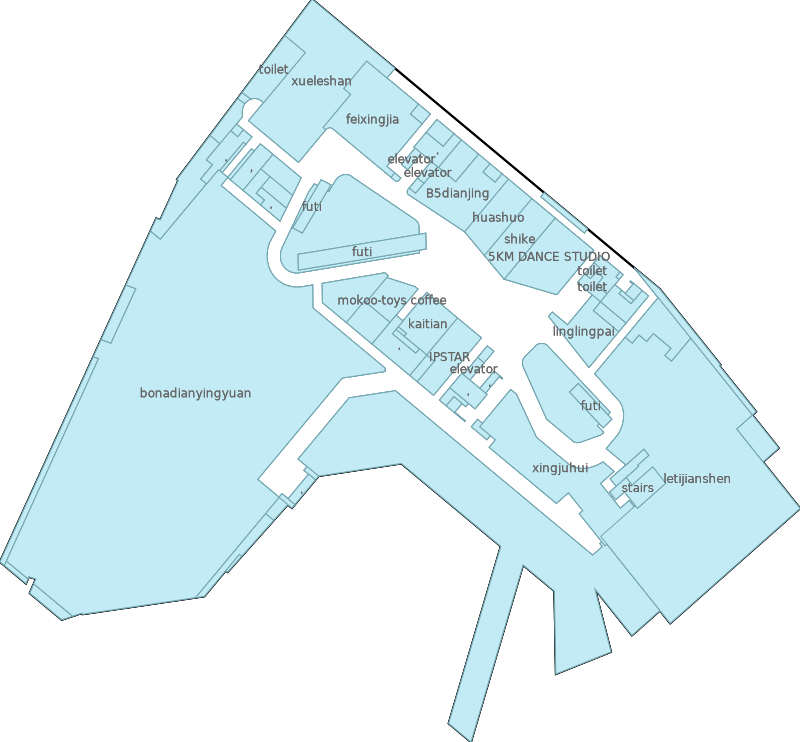

In [18]:
# Visualization
label, loss = evaluate(model1, test_set)
visualize(label, loss, dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



(2090,)
[Test] loss: 0.019



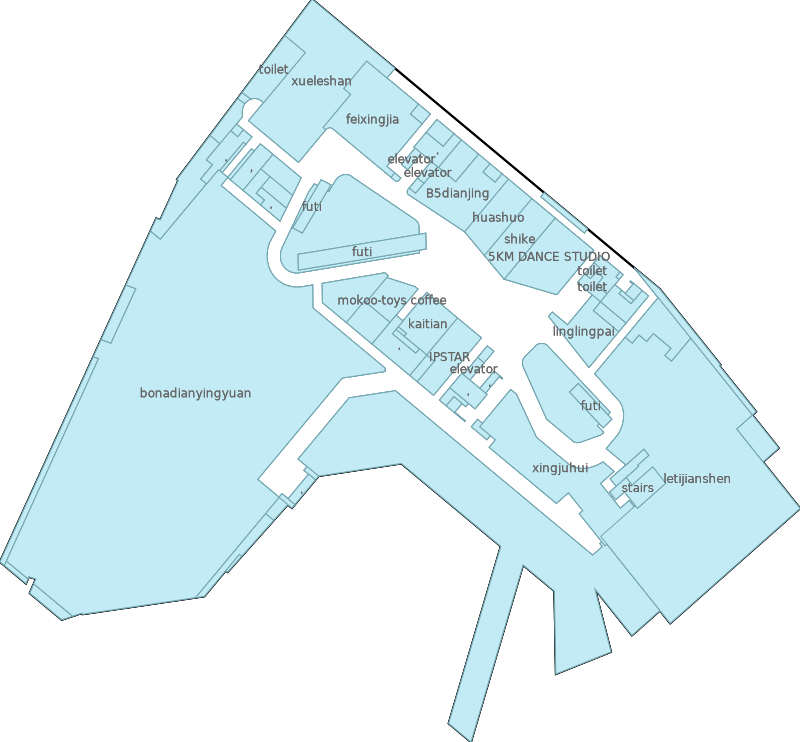

In [19]:
# Visualization
label, loss = evaluate(model1, all_set)
visualize(label, loss, dataset)

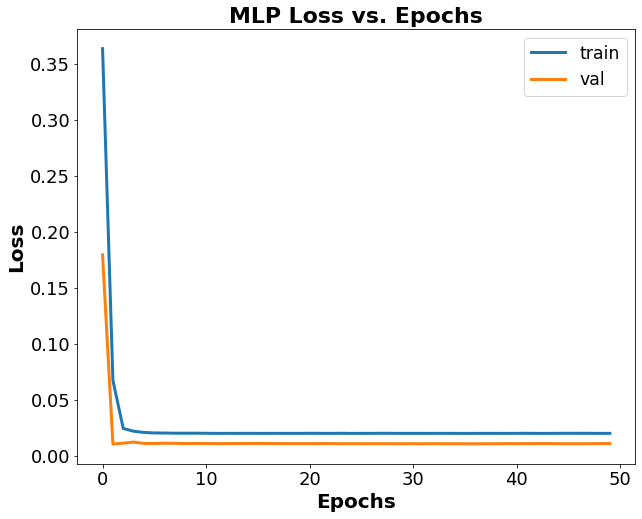

In [20]:
# plot loss
plt.figure(figsize=(10, 8))
plt.title("MLP Loss vs. Epochs", fontsize=22, weight='bold')
plt.plot(train_loss_list, linewidth=3.0, label="train")
plt.plot(test_loss_list, linewidth=3.0, label="val")
plt.xlabel("Epochs", fontsize=20, weight='bold')
plt.ylabel("Loss", fontsize=20, weight='bold')
plt.tick_params(labelsize=18)
plt.legend(fontsize='xx-large')
# plt.savefig("./loss_WD2.png")
plt.show()